In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Successfully built gast absl-py termcolor wrapt


ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.16.4)


In [3]:
# Use CPU only
# Only Macbook needs to run this cell
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [23]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization

## Load data and do data normalization

In [2]:
df = pd.read_csv('Options.csv')
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,underlying_price,interest_rate,cp_flag_C,cp_flag_P
0,AXP,2013-01-02,2013-01-04,2,60.0,0.03,0.181376,58.75,0.0008,1,0
1,AXP,2013-01-02,2013-01-04,2,62.5,0.05,0.450289,58.75,0.0008,1,0
2,AXP,2013-01-02,2013-01-04,2,65.0,0.05,0.676564,58.75,0.0008,1,0
3,AXP,2013-01-02,2013-01-04,2,67.5,0.50,1.369425,58.75,0.0008,1,0
4,AXP,2013-01-02,2013-01-04,2,70.0,0.01,0.888123,58.75,0.0008,1,0


In [3]:
df = df[df['interest_rate'].notnull()]

In [5]:
y = df['best_offer']
X = df[['maturity', 'strike_price', 'underlying_price', 'cp_flag_C', 'cp_flag_P', 'interest_rate']]

In [6]:
# Normalize the data to build a regression neural network model
sc= preprocessing.MinMaxScaler()
X= sc.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)
print(y_train.shape)

(1559488, 6)
(1559488,)


In [9]:
XX_train, XX_validation, yy_train, yy_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Build a keras Sequential model

In [10]:
# Built Keras sequential model with 3 hidden layer, and after the first hidden layer.
model = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

W0705 20:23:12.838638 10036 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 20:23:12.853649 10036 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 20:23:12.858652 10036 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [11]:
# Enable early stopping based on the loss of validation data
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

In [12]:
# Because it is a simple regression problem, we should custom metrics function
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [13]:
# use mean_squared_error to compile regression model loss
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)

W0705 20:23:23.027426 10036 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [14]:
# fit the model
result = model.fit(XX_train, 
                   yy_train,
                   epochs = 100,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0705 20:23:43.079288 10036 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0705 20:23:43.224327 10036 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1247590 samples, validate on 311898 samples
Epoch 1/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 9.4229 - rmse: 0.8669 - r_square: 0.9537 - val_loss: 0.4624 - val_rmse: 0.4395 - val_r_square: 0.9976
Epoch 2/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.3911 - rmse: 0.3857 - r_square: 0.9980 - val_loss: 0.3830 - val_rmse: 0.3720 - val_r_square: 0.9980
Epoch 3/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.3707 - rmse: 0.3761 - r_square: 0.9981 - val_loss: 0.3912 - val_rmse: 0.3945 - val_r_square: 0.9980
Epoch 4/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.3421 - rmse: 0.3625 - r_square: 0.9982 - val_loss: 0.2950 - val_rmse: 0.3327 - val_r_square: 0.9985
Epoch 5/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.3222 - rmse: 0.3522 - r_square: 0.9983 - val_loss: 0.3065 - val_rmse: 0.3346 - val_r_square: 0.9984
Epoch 6/100
1247590/12

Epoch 45/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2353 - rmse: 0.2953 - r_square: 0.9988 - val_loss: 0.2466 - val_rmse: 0.2979 - val_r_square: 0.9987
Epoch 46/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2339 - rmse: 0.2946 - r_square: 0.9988 - val_loss: 0.2496 - val_rmse: 0.3010 - val_r_square: 0.9987
Epoch 47/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2342 - rmse: 0.2946 - r_square: 0.9988 - val_loss: 0.2249 - val_rmse: 0.2827 - val_r_square: 0.9988
Epoch 48/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2315 - rmse: 0.2929 - r_square: 0.9988 - val_loss: 0.2289 - val_rmse: 0.2867 - val_r_square: 0.9988
Epoch 49/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2321 - rmse: 0.2935 - r_square: 0.9988 - val_loss: 0.2386 - val_rmse: 0.3001 - val_r_square: 0.9988
Epoch 50/100
1247590/1247590 [==============================] - 6s 5us

1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2118 - rmse: 0.2803 - r_square: 0.9989 - val_loss: 0.2270 - val_rmse: 0.2798 - val_r_square: 0.9988
Epoch 90/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2113 - rmse: 0.2796 - r_square: 0.9989 - val_loss: 0.2018 - val_rmse: 0.2669 - val_r_square: 0.9990
Epoch 91/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2107 - rmse: 0.2794 - r_square: 0.9989 - val_loss: 0.2053 - val_rmse: 0.2714 - val_r_square: 0.9989
Epoch 92/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2103 - rmse: 0.2790 - r_square: 0.9989 - val_loss: 0.2350 - val_rmse: 0.2901 - val_r_square: 0.9988
Epoch 93/100
1247590/1247590 [==============================] - 6s 5us/step - loss: 0.2102 - rmse: 0.2790 - r_square: 0.9989 - val_loss: 0.2180 - val_rmse: 0.2906 - val_r_square: 0.9989
Epoch 94/100
1247590/1247590 [==============================] - 6s 5us/step - loss:

In [20]:
model.save('model3.h5')

In [15]:
predictions = model.predict(X_test)
print(predictions[:10])

[[4.4757307e-02]
 [8.6236984e-02]
 [1.0375798e+00]
 [1.8603920e+00]
 [1.1812827e-01]
 [1.3241207e+01]
 [3.0101727e+01]
 [8.8977137e+00]
 [9.4007206e+00]
 [4.9212929e+01]]


In [16]:
y_test[:10]

593616      0.02
1410840     0.12
1300486     1.12
734479      1.50
350525      0.04
1653947    12.55
1085111    30.55
1093566     8.30
224536      9.40
279697     50.65
Name: best_offer, dtype: float64

## Plot learning curves including R^2 and RMSE

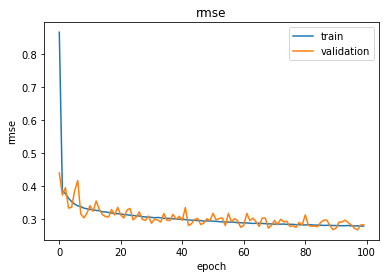

In [17]:
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

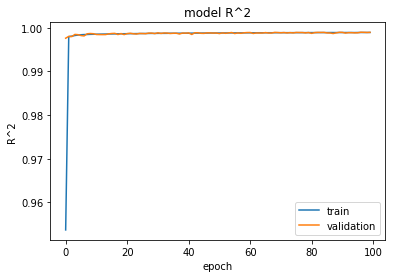

In [18]:
# plot training curve for R^2
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [19]:
import sklearn.metrics as skm, math
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions))



Mean absolute error (MAE):      0.280542
Mean squared error (MSE):       0.201587
Root mean squared error (RMSE): 0.448984
R square (R^2):                 0.999020


## Try dropout

In [21]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model2.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result2 = model2.fit(XX_train, 
                   yy_train,
                   epochs = 100,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0705 20:40:05.340076 10036 deprecation.py:506] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 1247590 samples, validate on 311898 samples
Epoch 1/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 11.4388 - rmse: 1.3180 - r_square: 0.9420 - val_loss: 0.5858 - val_rmse: 0.4638 - val_r_square: 0.9970
Epoch 2/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 1.3110 - rmse: 0.6532 - r_square: 0.9934 - val_loss: 0.9249 - val_rmse: 0.6207 - val_r_square: 0.9953
Epoch 3/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 0.8679 - rmse: 0.5480 - r_square: 0.9956 - val_loss: 1.1892 - val_rmse: 0.6683 - val_r_square: 0.9941
Epoch 4/100
1247590/1247590 [==============================] - 7s 5us/step - loss: 0.6364 - rmse: 0.4771 - r_square: 0.9967 - val_loss: 1.4994 - val_rmse: 0.6939 - val_r_square: 0.9926
Epoch 5/100
1247590/1247590 [==============================] - 7s 5us/step - loss: 0.5191 - rmse: 0.4367 - r_square: 0.9973 - val_loss: 1.7003 - val_rmse: 0.6712 - val_r_square: 0.9917
Epoch 6/100
1247590/1

In [22]:
predictions2 = model2.predict(X_test)
print(predictions2[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions2))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions2))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions2)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions2))

[[2.3238823e-02]
 [9.9141829e-02]
 [9.3901718e-01]
 [2.3249245e+00]
 [1.9514221e-01]
 [1.1731058e+01]
 [2.7127060e+01]
 [8.1401424e+00]
 [8.2319689e+00]
 [4.4056717e+01]]


Mean absolute error (MAE):      0.824509
Mean squared error (MSE):       2.804126
Root mean squared error (RMSE): 1.674553
R square (R^2):                 0.986366


## Try batch normalization technique to regularize neurons

In [25]:
model3 = Sequential([
    BatchNormalization(),
    Dense(64, activation='relu', input_shape=(6,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model3.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result3 = model3.fit(XX_train, 
                   yy_train.values,
                   epochs =100,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation.values),
                   callbacks = [es]
                  )

Train on 1247590 samples, validate on 311898 samples
Epoch 1/100
1247590/1247590 [==============================] - 8s 6us/step - loss: 7.9399 - rmse: 1.2601 - r_square: 0.9605 - val_loss: 0.6608 - val_rmse: 0.5444 - val_r_square: 0.9966
Epoch 2/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 3.4927 - rmse: 1.0205 - r_square: 0.9823 - val_loss: 1.1085 - val_rmse: 0.6601 - val_r_square: 0.9943
Epoch 3/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 3.2452 - rmse: 0.9784 - r_square: 0.9837 - val_loss: 0.9889 - val_rmse: 0.5816 - val_r_square: 0.9949
Epoch 4/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 3.3106 - rmse: 0.9762 - r_square: 0.9832 - val_loss: 0.9306 - val_rmse: 0.6041 - val_r_square: 0.9952
Epoch 5/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 3.1642 - rmse: 0.9477 - r_square: 0.9839 - val_loss: 1.7566 - val_rmse: 0.7734 - val_r_square: 0.9910
Epoch 6/100
1247590/12

Epoch 45/100
1247590/1247590 [==============================] - 7s 5us/step - loss: 2.9148 - rmse: 0.8928 - r_square: 0.9852 - val_loss: 0.6064 - val_rmse: 0.4566 - val_r_square: 0.9969
Epoch 46/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 2.9562 - rmse: 0.8957 - r_square: 0.9850 - val_loss: 0.3202 - val_rmse: 0.3359 - val_r_square: 0.9984
Epoch 47/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 2.9480 - rmse: 0.8964 - r_square: 0.9852 - val_loss: 0.3197 - val_rmse: 0.3468 - val_r_square: 0.9984
Epoch 48/100
1247590/1247590 [==============================] - 7s 6us/step - loss: 2.9550 - rmse: 0.8992 - r_square: 0.9851 - val_loss: 0.4523 - val_rmse: 0.4012 - val_r_square: 0.9977
Epoch 49/100
1247590/1247590 [==============================] - 7s 5us/step - loss: 2.9192 - rmse: 0.8952 - r_square: 0.9851 - val_loss: 0.3548 - val_rmse: 0.3626 - val_r_square: 0.9982
Epoch 00049: early stopping


In [26]:
predictions3 = model3.predict(X_test)
print(predictions3[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions3))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions3))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions3)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions3))

[[6.3048780e-02]
 [3.8709402e-02]
 [1.3599184e+00]
 [1.8800478e+00]
 [1.3280153e-02]
 [1.3064846e+01]
 [3.0613249e+01]
 [8.2126007e+00]
 [8.6445322e+00]
 [4.7861221e+01]]


Mean absolute error (MAE):      0.361444
Mean squared error (MSE):       0.352840
Root mean squared error (RMSE): 0.594003
R square (R^2):                 0.998284


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>